In [10]:
# Configuration parameters
RESULT_FOLDER = "data/input/conv_impl_precom_gemm/"
ALPHA = 0.05
MANUAL_EXPERIMENT_COUNT = 48000
EXPERIMENT_DURATION_SEC = 5

MIN_PRECISION = 0.005
RELATIVE_PRECISION = 0.25
MAX_PRECISION = 0.05

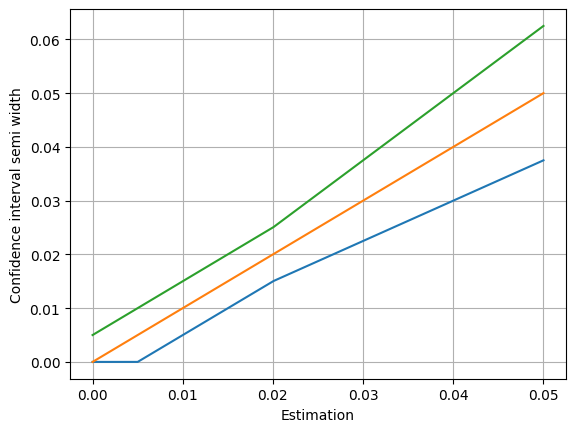

In [11]:
def clamp(val, min_v, max_v):
    if val < min_v:
        return min_v
    if val > max_v:
        return max_v
    return val

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 0.05, 1000)

y_small = [clamp(x_i - clamp(x_i * RELATIVE_PRECISION, MIN_PRECISION, MAX_PRECISION), 0, 1.0)  for x_i in x]
y_center = [x_i for x_i in x]
y_big = [clamp(x_i + clamp(x_i * RELATIVE_PRECISION, MIN_PRECISION, MAX_PRECISION), 0, 1.0)  for x_i in x]

plt.plot(x, y_small, label="lower limit")
plt.plot(x, y_center, label="center")
plt.plot(x, y_big, label="higher limit")
plt.xlabel('Estimation')
plt.ylabel('Confidence interval semi width')
plt.title('')
plt.grid(True)
plt.show()

In [12]:
from scipy.stats import chi2

def calculate_B(r, k):
    # Calculate the upper r times 100-th percentile
    q = 1 - (r / k)

    # Calculate B using the inverse of the cumulative distribution function (ppf)
    B = chi2.ppf(q, df=1)

    return B


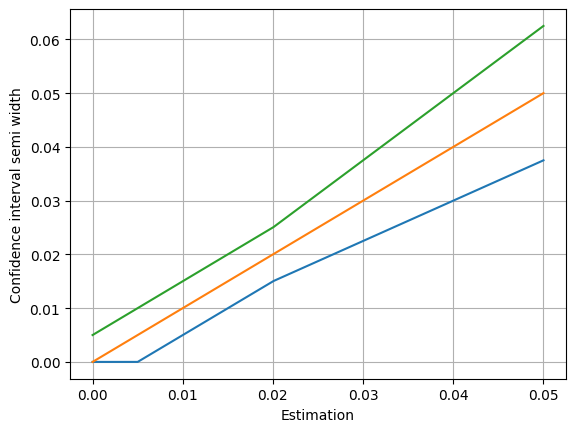

In [13]:
def clamp(val, min_v, max_v):
    if val < min_v:
        return min_v
    if val > max_v:
        return max_v
    return val

import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(0, 0.05, 1000)


y_small = [clamp(x_i - clamp(x_i * RELATIVE_PRECISION, MIN_PRECISION, MAX_PRECISION), 0, 1.0)  for x_i in x]
y_center = [x_i for x_i in x]
y_big = [clamp(x_i + clamp(x_i * RELATIVE_PRECISION, MIN_PRECISION, MAX_PRECISION), 0, 1.0)  for x_i in x]

plt.plot(x, y_small, label="lower limit")
plt.plot(x, y_center, label="center")
plt.plot(x, y_big, label="higher limit")
plt.xlabel('Estimation')
plt.ylabel('Confidence interval semi width')
plt.title('')
plt.grid(True)
plt.show()

In [14]:
def estimate_sample_size(k, p, d, alpha=0.05):
    B = calculate_B(alpha, k)
    return B * p * (1 - p) / (d * d)

In [15]:
from statsmodels.stats.proportion import multinomial_proportions_confint
import json
import os

STATS_FILE = os.path.join(RESULT_FOLDER, 'stats.json')

CONFINT_PCT = (1 - ALPHA) * 100

with open(STATS_FILE, 'r') as f:
    stats = json.load(f)
all_stats_list = list(stats.items())
all_cells = [key for key, val in all_stats_list]
all_frequencies = [val for key, val in all_stats_list]

stats_list = [(key, val) for key, val in all_stats_list if val >= 5]
cells = [key for key, val in stats_list]
frequencies = [val for key, val in stats_list]


n_cells = len(stats)
multinom_confints = multinomial_proportions_confint(frequencies, alpha = ALPHA, method='goodman')
n_corrupted = sum(all_frequencies)
print(f'Number of corrupted tensors: {n_corrupted}')
print(f'Number of cells: {n_cells}')
significative = sum(i for i in frequencies if i >= 5)
print(f'Percentage of corrupted tensors in the cells that have at least 5 extractions: {significative / n_corrupted * 100}%')

print(f'Highest estimated frequency: {frequencies[0] / n_corrupted:.4f}. Confidence interval at {CONFINT_PCT}%: {multinom_confints[0]}')
print(f'Lowest estimated frequency: {frequencies[-1] / n_corrupted:.4f}. Confidence interval at {CONFINT_PCT}%: {multinom_confints[-1]}')

Number of corrupted tensors: 7541
Number of cells: 296
Percentage of corrupted tensors in the cells that have at least 5 extractions: 95.1597931308845%
Highest estimated frequency: 0.2974. Confidence interval at 95.0%: [0.29394    0.33182518]
Lowest estimated frequency: 0.0007. Confidence interval at 95.0%: [0.00016752 0.00289318]


In [16]:
from statsmodels.stats.proportion import proportion_confint

REPORT_FILE = os.path.join(RESULT_FOLDER, 'global_report.json')

with open(REPORT_FILE, 'r') as f:
    report = json.load(f)

if "total_experiments" in report and report["total_experiments"] is not None:
    experiments = report["total_experiments"]
else:
    experiments = MANUAL_EXPERIMENT_COUNT
    print('No total_experiment field found in report. Using manual one')

print(f'Experiment count: {experiments}')


successes = report["classified_tensors"]
sdc_estimate = successes / experiments
sdc_confint = proportion_confint(successes, experiments, alpha=ALPHA, method='normal')
print(f'Estimation of SDC probability: {sdc_estimate:.6f}. Confidence interval at {CONFINT_PCT}%: {sdc_confint}')
print(f'Sampling multiplicative factor: {1/sdc_estimate:.6f}, Confidence interval at {CONFINT_PCT}%: {(1 / sdc_confint[1], 1 / sdc_confint[0])}')



Experiment count: 16094
Estimation of SDC probability: 0.468560. Confidence interval at 95.0%: (0.4608502189867944, 0.4762692044008035)
Sampling multiplicative factor: 2.134200, Confidence interval at 95.0%: (2.09965286598386, 2.1699024082022946)


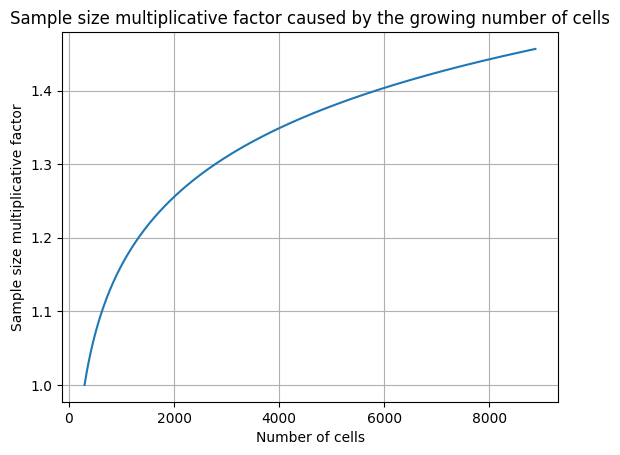

Current number of cells: 296


In [17]:
import matplotlib.pyplot as plt
import numpy as np

k_min = n_cells
k_max = 30 * n_cells

x = np.linspace(k_min, k_max, 1500)

y = [calculate_B(ALPHA, k_i) / calculate_B(ALPHA, k_min)  for k_i in x]

plt.plot(x, y)
plt.xlabel('Number of cells')
plt.ylabel('Sample size multiplicative factor')
plt.title('Sample size multiplicative factor caused by the growing number of cells')
plt.grid(True)
plt.show()

print(f"Current number of cells: {n_cells}")

In [18]:
import math
estimate_n_cells = int(2.0 * n_cells)

max_sample_size = 0
max_sample_size_idx = None
max_sample_size_precision = None

for i, confint in enumerate(multinom_confints):
    if frequencies[i] < 5:
        continue
    estimate_p = frequencies[i] / n_corrupted
    desired_precision = max(MIN_PRECISION, min(estimate_p / 4, MAX_PRECISION))
    est_sample_size = estimate_sample_size(alpha=ALPHA, k = estimate_n_cells, p=estimate_p, d = desired_precision)
    if est_sample_size > max_sample_size:
        max_sample_size = est_sample_size
        max_sample_size_idx = i
        max_sample_size_precision = desired_precision

total_injections_required = int(math.ceil(max_sample_size / sdc_estimate))
remaining_corr_tensors = int(math.ceil(max_sample_size - n_corrupted))


print(f"Cell that requires the highest sample size: {cells[max_sample_size_idx]} with frequency {frequencies[max_sample_size_idx] / n_corrupted:.6f}")
print(f"Estimated precision for that cell: {desired_precision}")

print(f"Estimated Total of corrupted tensors required: {int(math.ceil(max_sample_size))}")
print(f"Estimated Total injections required: {int(math.ceil(total_injections_required))}")

if remaining_corr_tensors > 0:
    print(f"Estimated number of corrupted tensors remaining: {remaining_corr_tensors}")

    remaining_injections = int(math.ceil(remaining_corr_tensors / sdc_estimate))

    print(f"Estimated number of injections remaining: {remaining_injections}")
    print(f"Estimated duration of the next campaign: {remaining_injections * EXPERIMENT_DURATION_SEC / 60 / 60 / 24:.5f} days")
else:
    print(f"No corrupted tensors left to obtain")


Cell that requires the highest sample size: (16, 'skip_4', ((0, (0, 4, 8, 12)), (4, (0, 4, 8, 12)), (8, (0, 4, 8, 12)), (12, (0, 4, 8, 12)))) with frequency 0.016576
Estimated precision for that cell: 0.005
Estimated Total of corrupted tensors required: 10078
Estimated Total injections required: 21509
Estimated number of corrupted tensors remaining: 2537
Estimated number of injections remaining: 5415
Estimated duration of the next campaign: 0.31337 days
